In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from keras.utils import to_categorical
from numpy import array
import keras
from keras import regularizers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Conv1D,GlobalMaxPooling1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from numpy import array
from numpy import asarray
from numpy import zeros
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir('drive/My Drive/nlp assignment 3')

In [0]:
#Preprocessing Train and Test data.
a = open('train.txt')
b = open('test.txt')
sentences = []
test_sentences = []
train_text = a.readlines()
test_text = b.readlines()
sentence = [train_text[0].split()[2]]
test_sentence = [test_text[0].split()[2]]
test_sentence = [test_text[0].split()[2]]
for line in test_text[1:]:
  ls = line.split()
  try:
    # print(ls)
    if ls[0]=='meta':
      test_sentences.append(test_sentence)
      test_sentence = [ls[2]]
    else:
      test_sentence.append([ls[0], ls[1]])
  except:
    continue
for line in train_text[1:]:
  # print(line.split())
  ls = line.split()
  try:
    # print(ls)
    if ls[0]=='meta':
      sentences.append(sentence)
      sentence = [ls[2]]
    else:
      sentence.append([ls[0], ls[1]])
  except:
    continue
a.close()
b.close()

In [0]:

hin_dict = set()
s = ""
translated_sentences = list(sentences)
y_train = []
x_train = []
# translations = translator.translate([s], dest='en')
for sen_num,sentence in enumerate(sentences):
  # print(sentence[0])
  # break
  if sentence[0]=="positive":
    y_train.append(0)
  elif sentence[0]=="negative":
    y_train.append(1)
  elif sentence[0]=="neutral":
    y_train.append(2)
  new_sentence = ""
  for i in (sentence[1:]):
    if i[1]=="Hin":
        new_sentence += i[0]+" "
    else:  
      new_sentence += i[0]+" "
  x_train.append(new_sentence)

In [0]:
s = ""
test_translated_sentences = list(test_sentences)
y_test = []
x_test = []
for sen_num,sentence in enumerate(test_sentences):
  if sentence[0]=="positive":
    y_test.append(0)
  elif sentence[0]=="negative":
    y_test.append(1)
  elif sentence[0]=="neutral":
    y_test.append(2)
  new_sentence = ""
  for i in (sentence[1:]):
    if i[1]=="Hin":
        hin_dict.add(i[0])
        new_sentence += i[0]+" "
    else:  
      new_sentence += i[0]+" "
  x_test.append(new_sentence)

In [0]:
import re
def preprocess(sentences):
  # for sentence in sentences:
  new_sentences = list(sentences)
  for ct,sentence in enumerate(sentences):
    sentence = re.sub(r'[#,@,!,.,_,…,RT]*', "", sentence)
    sentence = sentence.lower()
    new_sentences[ct] = sentence
    for letter in range(len(sentence)):
      try:
        if sentence[letter:letter+4]=='http':
          print()
          new_sentences[ct] = sentence[:letter]
          break
      except:
        break
  return new_sentences

In [8]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)


In [0]:
max_words = 1000
max_len = 100
tokenizer_train = Tokenizer(num_words=5000)
tokenizer_train.fit_on_texts(x_train)
orig_y_test = y_test[:]
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
x_train = tokenizer_train.texts_to_sequences(x_train)
x_test = tokenizer_train.texts_to_sequences(x_test)
# sequences = tok.texts_to_sequences(X_train)
# sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [10]:
x_test[0]

[36, 1312, 46, 59, 3619, 3892, 428, 4733, 154, 2510, 72, 14, 3839, 2161, 69]

In [0]:
vocab_size_train = len(tokenizer_train.word_index) + 1

maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [12]:
x_test[1]

array([  16,   16,   16,   53,  979,  709, 1642, 1324,   59,   19, 2384,
        453,   87,  453,   87,  453,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [0]:
embeddings_dictionary_train = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary_train [word] = vector_dimensions
glove_file.close()

In [0]:
embedding_matrix_train = zeros((vocab_size_train, 100))
for word, index in tokenizer_train.word_index.items():
    embedding_vector = embeddings_dictionary_train.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[index] = embedding_vector

In [15]:
model = Sequential()
model.add(Embedding(vocab_size_train, 100, weights=[embedding_matrix_train], input_length=maxlen , trainable=True))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Conv1D(64, 10, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32, 10, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          4467300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 87, 64)            81984     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 34, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0  

In [16]:
history = model.fit(x_train ,y_train, batch_size=64, epochs=20, verbose=1, validation_data = (x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15130 samples, validate on 1868 samples
Epoch 1/20
15130/15130 [==============================] - 7s 461us/step - loss: 2.6810 - acc: 0.4336 - val_loss: 1.0655 - val_acc: 0.4764
Epoch 2/20
15130/15130 [==============================] - 4s 258us/step - loss: 0.9882 - acc: 0.5253 - val_loss: 1.0120 - val_acc: 0.5080
Epoch 3/20
15130/15130 [==============================] - 4s 265us/step - loss: 0.9241 - acc: 0.5751 - val_loss: 0.9887 - val_acc: 0.5268
Epoch 4/20
15130/15130 [==============================] - 4s 257us/step - loss: 0.8822 - acc: 0.6085 - val_loss: 1.0583 - val_acc: 0.5294
Epoch 5/20
15130/15130 [==============================] - 4s 264us/step - loss: 0.8424 - acc: 0.6320 - val_loss: 1.0488 - val_acc: 0.5412
Epoch 6/20
15130/15130 [==============================] - 4s 261us/step - loss: 0.8202 - acc: 0.6539 - val_loss: 1.1050 - val_acc: 0.5530
Epoch 7/20
15130/15130 [===

In [17]:
from sklearn.metrics import classification_report
y_pred=np.argmax(model.predict(x_test),axis=1)
print(classification_report(orig_y_test,y_pred))


              precision    recall  f1-score   support

           0       0.58      0.48      0.52       582
           1       0.55      0.48      0.51       532
           2       0.48      0.59      0.53       754

    accuracy                           0.52      1868
   macro avg       0.54      0.51      0.52      1868
weighted avg       0.53      0.52      0.52      1868



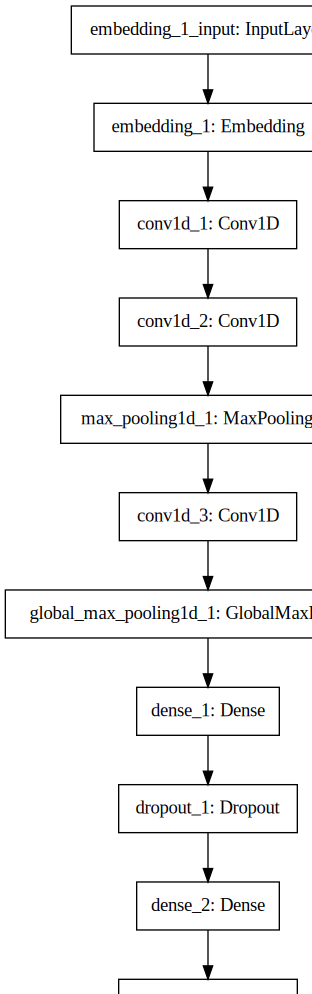

In [18]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

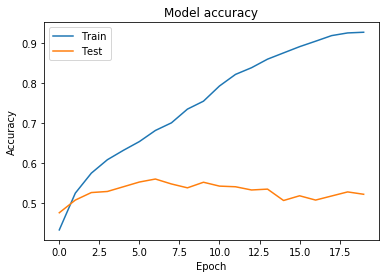

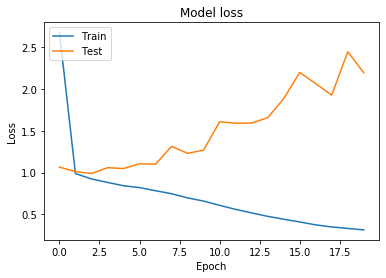

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()